In [1]:
import numpy as np
import pandas as pd
import math

# 모델 라이브러리 선언
from sklearn import datasets, tree
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

# 모델 정확도 라이브러리 선언
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
featuresData=pd.read_csv("./dataset/feature_regression_example.csv")

In [3]:
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155


In [4]:
featuresData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int64
YEAR              int64
WEEK              int64
QTY               int64
HOLIDAY          object
HCLUS             int64
PROMOTION        object
PRO_PERCENT     float64
dtype: object

In [5]:
featuresData["Ho_YN"]=np.where(featuresData["HOLIDAY"]=="Y",1,0,)
featuresData["PRO_YN"]=np.where(featuresData["PROMOTION"]=="Y",1,0)

featuresData["YEARWEEK"]=featuresData["YEARWEEK"].astype(int)
featuresData["YEAR"]=featuresData["YEAR"].astype(int)
featuresData["WEEK"]=featuresData["WEEK"].astype(int)
featuresData.head()


,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,Ho_YN,PRO_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1


In [6]:
featuresData=featuresData[(featuresData.YEARWEEK>=201501)&(featuresData.YEARWEEK<=201652)]
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,Ho_YN,PRO_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1


In [7]:
# 상관관계 확인
corrDf = featuresData.corr()
corrDf

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,Ho_YN,PRO_YN
YEARWEEK,1.000000,0.956598,0.275593,0.112267,-0.071586,0.404889,0.049867,0.205916
YEAR,0.956598,1.000000,-0.016493,0.028931,0.028593,0.321193,-0.031106,0.195931
WEEK,0.275593,-0.016493,1.000000,0.289766,-0.339943,0.329705,0.273710,0.060206
QTY,0.112267,0.028931,0.289766,1.000000,-0.537230,0.700195,0.505932,0.612451
HCLUS,-0.071586,0.028593,-0.339943,-0.537230,1.000000,-0.545619,-0.974601,-0.374072
PRO_PERCENT,0.404889,0.321193,0.329705,0.700195,-0.545619,1.000000,0.487062,0.898554
Ho_YN,0.049867,-0.031106,0.273710,0.505932,-0.974601,0.487062,1.000000,0.365148
PRO_YN,0.205916,0.195931,0.060206,0.612451,-0.374072,0.898554,0.365148,1.000000


In [8]:
# 인덱스컬럼 초기화
corrResult=corrDf.reset_index()
# 상관관계 계수 비율 선정
featuresStd = 0.5
# Feature 선택
features = corrResult[ (corrResult.QTY != 1) & (abs(corrResult.QTY) > featuresStd)]["index"].tolist()
label=['QTY']

In [9]:
features

['HCLUS', 'PRO_PERCENT', 'Ho_YN', 'PRO_YN']

In [10]:
# 데이터 분리
yearweekStd = 201630
trainingData_features = featuresData[featuresData.YEARWEEK <= yearweekStd][features]
trainingData_label = featuresData[featuresData.YEARWEEK <= yearweekStd][label]
testData_features = featuresData[featuresData.YEARWEEK > yearweekStd][features]
testData_label = featuresData[featuresData.YEARWEEK > yearweekStd]

In [11]:
# Define Model 모델 선언 및 학습
model_method = tree.DecisionTreeRegressor()
# model_method = linear_model.LinearRegression()

# Learning (Feature & Label)
model = model_method.fit(trainingData_features,trainingData_label) ##학습시킬때 feaure와 label둘다 학습시켜야한다.


In [12]:
# 예측
predict = model.predict(testData_features)
predict

array([1606.5       , 1606.5       ,  350.71428571, 1434.6       ,
       1434.6       , 1434.6       , 1434.6       , 1434.6       ,
       1606.5       , 1606.5       , 2620.42857143, 1606.5       ,
        350.71428571, 2193.8       , 2193.8       , 2193.8       ,
       2193.8       , 2193.8       , 1434.6       , 1434.6       ,
       1434.6       , 1434.6       ])

In [13]:
### 데이터프레임으로 변환
predictData1 = pd.DataFrame(predict)
predictData1.columns=["PREDICT"]#컬럼명 바꾸기!!
predictData1.head()

,PREDICT
0,1606.500000
1,1606.500000
2,350.714286
3,1434.600000
4,1434.600000


In [14]:
#테스트 데이터와 예측값을 붙이세요
testData_label=testData_label.reset_index(drop=True)

finalResult=pd.concat([testData_label,predictData1],axis=1)

finalResult.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,Ho_YN,PRO_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1606.500000
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1606.500000
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,350.714286
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1434.600000
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1434.600000


In [15]:
#결과검증

### MAE
mean_absolute_error(finalResult['QTY'], finalResult['PREDICT'])


402.7435064935065

In [16]:
### RMSE (MSE)
math.sqrt(mean_squared_error(finalResult['QTY'], finalResult['PREDICT']))

476.11553668877247

In [17]:
### R2
r2_score(finalResult['QTY'], finalResult['PREDICT']) 

0.5144917252719985

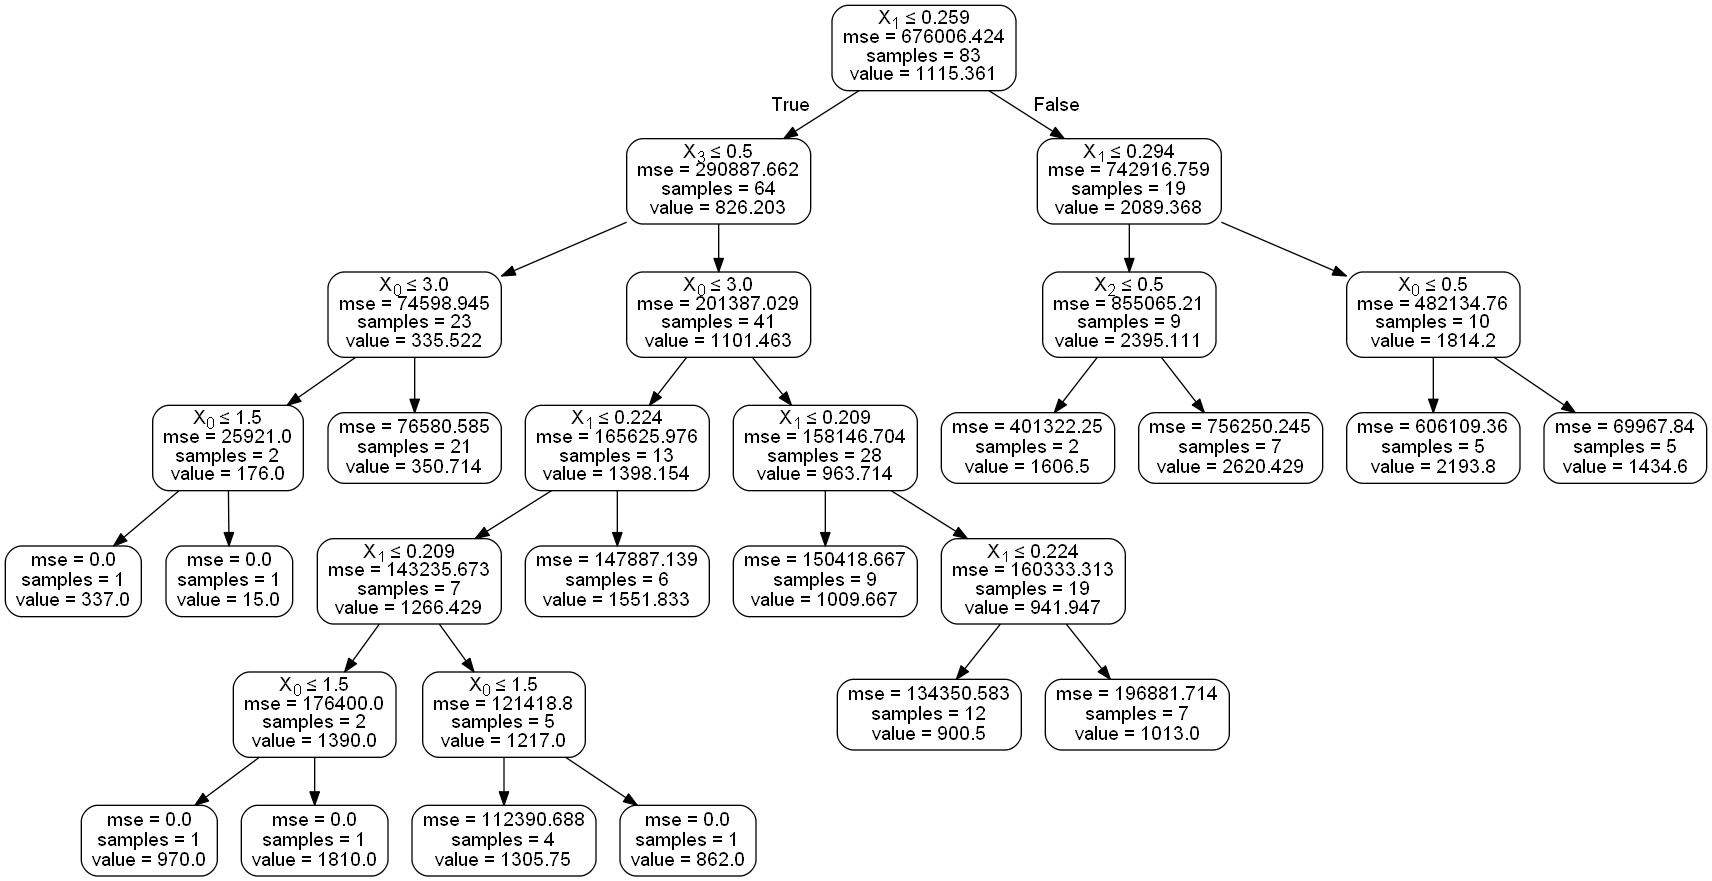

In [18]:
##시각화
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, 
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [19]:
# Define Model 모델 선언 및 학습
model_method1 = linear_model.LinearRegression()
# Learning (Feature & Label)
model1 = model_method1.fit(trainingData_features,trainingData_label) ##학습시킬때 feaure와 label둘다 학습시켜야한다.


In [20]:
# 예측
predict1 = model1.predict(testData_features)
predict1

array([[1411.29171929],
       [1411.29171929],
       [ 300.43091536],
       [2004.96200456],
       [2004.96200456],
       [2004.96200456],
       [1586.12154967],
       [1586.12154967],
       [1411.29171929],
       [1411.29171929],
       [1799.54021119],
       [1411.29171929],
       [ 300.43091536],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2734.87329525],
       [2285.44087736],
       [1856.31310796],
       [1856.31310796],
       [2275.15356285]])

In [21]:
predictData2 = pd.DataFrame(predict1)
predictData2.columns=["PREDICT2"]#컬럼명 바꾸기!!
predictData2.head()

,PREDICT2
0,1411.291719
1,1411.291719
2,300.430915
3,2004.962005
4,2004.962005


In [22]:
finalResult

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,Ho_YN,PRO_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1606.500000
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1606.500000
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,350.714286
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1434.600000
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1434.600000
5,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201636,2016,36,1501,Y,1,Y,0.308584,1,1,1434.600000
6,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201637,2016,37,1491,N,4,Y,0.308584,0,1,1434.600000
7,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201638,2016,38,806,N,4,Y,0.308584,0,1,1434.600000
8,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201639,2016,39,2111,N,4,Y,0.280258,0,1,1606.500000
9,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201640,2016,40,2400,N,4,Y,0.280258,0,1,1606.500000


In [23]:
finalResult=finalResult.reset_index(drop=True)

finalResult=pd.concat([finalResult,predictData2],axis=1)

finalResult.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,Ho_YN,PRO_YN,PREDICT,PREDICT2
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1606.500000,1411.291719
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1606.500000,1411.291719
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,350.714286,300.430915
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1434.600000,2004.962005
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1434.600000,2004.962005


In [24]:
### MAE
mean_absolute_error(finalResult['QTY'], finalResult['PREDICT2'])


566.617239476098

In [25]:
### RMSE (MSE)
math.sqrt(mean_squared_error(finalResult['QTY'], finalResult['PREDICT2']))

722.6052639386677

In [26]:
### R2
r2_score(finalResult['QTY'], finalResult['PREDICT2']) 

-0.11834080332946595

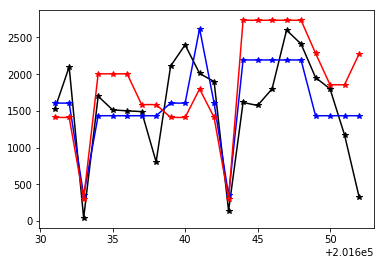

In [27]:
%matplotlib inline

x=finalResult['YEARWEEK']
y1=finalResult['QTY']
y2=finalResult['PREDICT']
y3=finalResult['PREDICT2']
plt.plot(x,y1, "k*-")
plt.plot(x,y2, "b*-")
plt.plot(x,y3, "r*-")